In [2]:
from __future__ import annotations
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.axes
import matplotlib.image
import matplotlib.figure
import matplotlib.collections
from matplotlib.animation import FuncAnimation

In [8]:
class Column:
    def __init__(self, analytes: list["Compound"], dimensions: Tuple[int, int], linear_flow: float = 1, film_thickness: float = 2, wall_thickness: float = 3, wall_color: str = "k", film_color: str = "y") -> None:
        if type(dimensions) is not (tuple or list or np.ndarray):
            raise TypeError("dimensions must be a tuple of two numbers with the signature (width, length)")
        if len(dimensions) != 2:
            raise IndexError("dimensions must consist of exactly two values: (width, length)")
        self._width, self._length = dimensions
        if not (isinstance(self._width, (float, int)) and isinstance(self._width, (float, int))):
            raise ValueError("the dimensions (width and length) must be numerical")
        if self._width <= 0:
            raise ValueError("the width must be a positive number above 0")
        if self._length <= 0:
            raise ValueError("the length must be a positive number above 0")
        self._inlet = (0, self._width/2)
        
        if not isinstance(linear_flow, (float, int)):
            raise TypeError(f"linear_flow must be a number, and not {type(linear_flow)}")
        if linear_flow < 0:
            raise ValueError("the linear flow must be a positive number")
        self._linear_flow = linear_flow
        
        if not isinstance(film_thickness, (float, int)):
            raise TypeError(f"film_thickness must be a number, and not {type(film_thickness)}")
        if film_thickness <= 0:
            raise ValueError("the film thickness must be a positive number above 0")
        if film_thickness*2 >= self._width:
            raise ValueError("the film is too thick to fit in the column")
        self._film_thickness = film_thickness
        
        if not isinstance(wall_thickness, (float, int)):
            raise TypeError(f"linear_flow must be a number, and not {type(wall_thickness)}")
        if wall_thickness <= 0:
            raise ValueError("the wall thickness must be a positive number above 0")
        self._wall_thickness = wall_thickness
        
        if not type(analytes) is list:
            print(type(analytes))
            raise TypeError("analytes must be a list of the analytes to be injected into the column")
        for a in analytes:
            if type(a) is not Compound:
                raise TypeError("each analyte must be an object of the class 'Compound'")
        self.analytes = analytes
        
        if type(wall_color) is not str:
            raise TypeError(f"wall_color must be of type 'str', and not '{type(wall_color)}'")
        self.wall_color = wall_color

        if type(film_color) is not str:
            raise TypeError(f"film_color must be of type 'str', and not '{type(film_color)}'")
        self.film_color = film_color
        
    @property
    def dimensions(self) -> Tuple:
        return self._width, self._length
    
    @property
    def film_thickness(self) -> float:
        return self._film_thickness
    
    @property
    def wall_thickness(self) -> float:
        return self._wall_thickness
    
    @property
    def linear_flow(self) -> float:
        return self._linear_flow
    
    def _plot_column(self):
        fig, ax = plt.subplots()
        ax.plot()

        bottomline = Rectangle((0, -self.wall_thickness), self._length, self.wall_thickness, facecolor = self.wall_color)
        topline = Rectangle((0, self._width), self._length, self.wall_thickness, facecolor = self.wall_color)
        ax.add_patch(bottomline)
        ax.add_patch(topline)
        
        bottomfilm = Rectangle((0, 0), self._length, self.film_thickness, facecolor = self.film_color)
        topfilm = Rectangle((0, self._width - self.film_thickness), self._length, self.film_thickness, facecolor = self.film_color)
        ax.add_patch(bottomfilm)
        ax.add_patch(topfilm)
        
        plt.ylim((self.wall_thickness - 20, self._width + self.wall_thickness + 20))
        plt.yticks([0, self._width])
        plt.xticks([0, self._length])
        ax.set_aspect('equal', adjustable = 'box')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        return fig, ax
        
    def plot_column(self) -> None:
        self._plot_column()
        plt.show()
        
    def animate_column(self, frames: int = 10000, size: float = 2, alpha: float = 0.001, interval: int = 1) -> None:
        if not isinstance(frames, int):
            raise TypeError("frames must be a positive integer")
        if frames < 0:
            raise ValueError("frames must be a positive integer")
        if not isinstance(size, (float, int)):
            raise TypeError("size must be numerical")
        if size <= 0:
            raise ValueError("size must be a positive number above 0")
        if not isinstance(alpha, (float, int)):
            raise TypeError("alpha must be a number between 0 and 1")
        if alpha < 0 or alpha > 1:
            raise ValueError("alpha must be a number between 0 and 1")
        
        fig, ax = self._plot_column()
        fig.set_figwidth(12.5)
        ax.set_title("Frame 0")
        scatters = [0]*len(self.analytes)
        for j in range(len(self.analytes)):
            compound = self.analytes[j]
            compound.initialize_walkers(self._inlet)
            scat = ax.scatter(compound.x, compound.y, c = compound.color, s = size, alpha = alpha)
            scatters[j] = scat
        
        def update_frame(i: int):
            ax.set_title(f"Frame {i}")
            for k in range(len(self.analytes)):
                compound = self.analytes[k]
                compound.move(self._length, self._width, self.film_thickness, self.linear_flow)
                x = np.array(compound.x)
                y = np.array(compound.y)
                data = np.stack([x, y]).T
                s = scatters[k]
                s.set_offsets(data)
                scatters[k] = s
            return tuple(scatters)
        
        ani = FuncAnimation(fig = fig, func = update_frame, frames = frames, interval = interval)
        plt.show()
        return ani
    
    def plot_histogram(self, binwidth: float = 20, gauss: bool = True, filename: str = None) -> None:
        if not isinstance(binwidth, (float, int)):
            raise TypeError("binwidth must be numerical")
        if binwidth <= 0:
            raise ValueError("binwidth cannot be 0 or below")
            
        if not isinstance(gauss, bool):
            raise TypeError("gauss must be boolean (True or False)")
        
        for stoff in self.analytes:
            dist = np.array(stoff.distribution)
            bins = int((max(dist) - min(dist))/binwidth + 1)
    
            plt.hist(dist, bins=bins, color=stoff.color, density=True, alpha=0.5)
    
            if gauss == True:
                sigma = stoff.std
                mu = stoff.mean
                gauss_curve = lambda x: 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x - mu)/sigma)**2)
                x = np.linspace(min(dist) - 5, max(dist) + 5, 1000)
                plt.plot(x, gauss_curve(x), linestyle="--", color=stoff.color)
    
        plt.xlabel("Tid")
        plt.ylabel("Relativ forekomst")
        plt.title(f"Kromatogram")
        
        if filename is not None:
            if not isinstance(filename, str):
                raise TypeError("filename must be of type 'str'")
            plt.savefig("filename")
        
        plt.show()

In [9]:
class Compound:
    def __init__(self, color: str, interaction: float = 0, N: int = 1000) -> None:
        if not isinstance(interaction, (float, int)):
            raise TypeError(f"interaction must be numerical, and not of type '{type(interaction)}'")
        if interaction < 0 or interaction > 1:
            raise ValueError(f"interaction must be a number between 0 and 1")
        self._interaction = interaction
        
        if not isinstance(N, int):
            raise TypeError(f"the number of particles, N, must be an integer, and not of type '{type(N)}'")
        if N < 0:
            raise ValueError("the number of particles, N, must be a positive integer")
        self._N = N
        self._rng = np.random.default_rng()
        self.distribution = []
        self._counter = 0
        self._max_diffusion = 1
        
        if not isinstance(color, str):
            raise TypeError(f"the color must be of type 'str', and not '{type(color)}'")
        self.color = color
        
    def initialize_walkers(self, r0) -> None:
        r = np.zeros((self._N, 2))
        r[:, 0] = r0[0]
        r[:, 1] = r0[1]
        self._r = r
        
    @property
    def x(self) -> np.ndarray:
        return self._r[:, 0]
    
    @property
    def y(self) -> np.ndarray:
        return self._r[:, 1]
    
    def move(self, length: float, width: float, film_thickness: float, linear_flow: float) -> None:
        p = self._interaction
        self._r = self._not_finished(length)
        dr = np.zeros((self._N, 2))
        idx_upper = self.y >= width - film_thickness
        idx_lower = self.y <= film_thickness
        dx_upper = self._rng.uniform(low = -self._max_diffusion, high = self._max_diffusion, size = np.count_nonzero(idx_upper)) + linear_flow
        dx_lower = self._rng.uniform(low = -self._max_diffusion, high = self._max_diffusion, size = np.count_nonzero(idx_lower)) + linear_flow
        dy_upper = self._rng.uniform(low = -self._max_diffusion, high = 0, size = np.count_nonzero(idx_upper))
        dy_lower = self._rng.uniform(low = 0, high = self._max_diffusion, size = np.count_nonzero(idx_lower))
        idx_stuck_upper = self._rng.choice([0, 1], size = np.count_nonzero(idx_upper), p = (1 - self._interaction, self._interaction)).astype(bool)
        idx_stuck_lower = self._rng.choice([0, 1], size = np.count_nonzero(idx_lower), p = (1 - self._interaction, self._interaction)).astype(bool)
        dx_upper[idx_stuck_upper] = 0
        dx_lower[idx_stuck_lower] = 0
        dy_upper[idx_stuck_upper] = 0
        dy_lower[idx_stuck_lower] = 0
        dr[idx_upper] = np.array([dx_upper, dy_upper]).T
        dr[idx_lower] = np.array([dx_lower, dy_lower]).T
        number_on_sp = np.count_nonzero(idx_upper) + np.count_nonzero(idx_lower)
        idx_on_sp = idx_upper + idx_lower
        dx = self._rng.uniform(low = -self._max_diffusion, high = self._max_diffusion, size = self._N - number_on_sp) + linear_flow
        dy = self._rng.uniform(low = -self._max_diffusion, high = self._max_diffusion, size = self._N - number_on_sp)
        dr[idx_on_sp == False] = np.array([dx, dy]).T
        self._r += dr
        self._dont_move_outside_column(length, width)
        self._counter += 1
        
    def _not_finished(self, length: float) -> np.ndarray:
        idx = self.x >= length
        not_finished = self._r[idx == False]
        number_of_finished = np.count_nonzero(idx)
        self._N -= number_of_finished
        
        for i in range(number_of_finished):
            self.distribution.append(self._counter)
            
        return not_finished
    
    def _dont_move_outside_column(self, length: float, width: float) -> None:
        x = self._r[:, 0]
        idx = x < 0
        x[idx] = 0
        self._r[:, 0] = x
        
        y = self._r[:, 1]
        idx_low = y < 0
        idx_high = y > width 
        y[idx_low] = 0
        y[idx_high] = width
        self._r[:, 1] = y
        
    @property
    def std(self) -> float:
        """Standard deviation of the time the walkers spent in the collumn."""
        return np.std(self.distribution, ddof=1)
    
    @property
    def mean(self) -> float:
        """Mean time spent in the collumn by the walkers."""
        return np.mean(self.distribution)

<IPython.core.display.Javascript object>


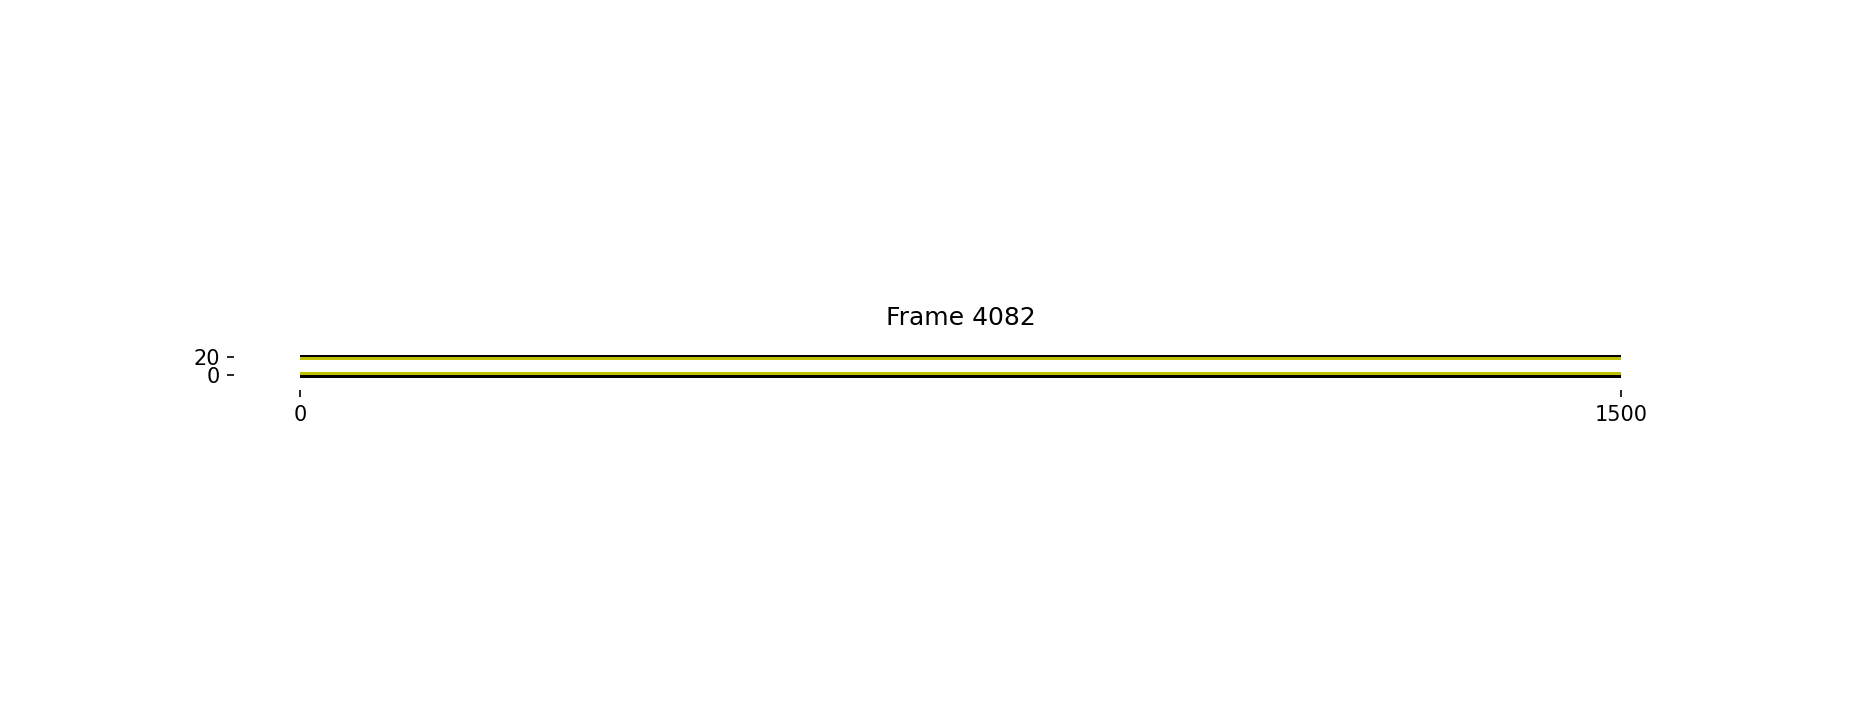

In [14]:
%matplotlib notebook
dimensions = (20, 1500)
stoff1 = Compound(color="#003b6f", interaction=0.4, N=5000)
stoff2 = Compound(color="hotpink", interaction=0.8, N=5000)

c = Column(analytes=[stoff1, stoff2], dimensions=dimensions, film_thickness=3, linear_flow=0.5, wall_color="k", film_color="y")
c.animate_column(frames=10000, size=1, alpha=0.01, interval=0.5)

<IPython.core.display.Javascript object>


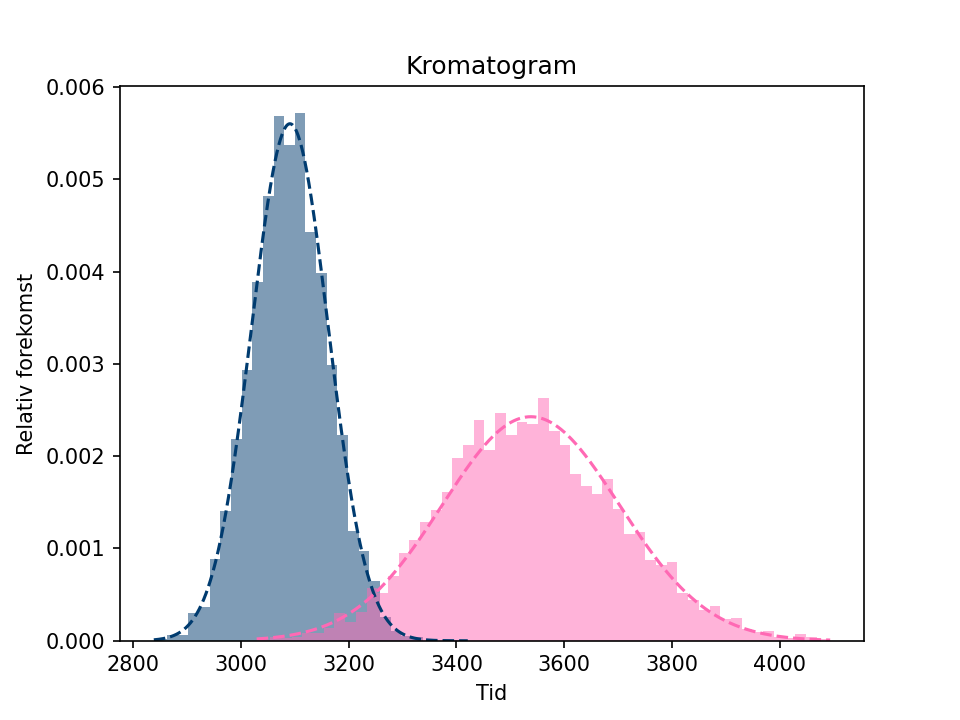

In [15]:
c.plot_histogram(binwidth=20, gauss=True)

In [16]:
print(f"Retensjonstid blå: {stoff1.mean}")
print(f"Retensjonstid rosa: {stoff2.mean}")

Retensjonstid blå: 3090.7246
Retensjonstid rosa: 3538.095076060849
